# Título  gbtd con envío
## Autor: Jose Chelquer
## Fecha de última modificación: 27/10/2024
## Descripción:

Hace lightbt y envía

## Parámetros

< Descripción de cada uno de los parámetros que utiliza el job >


In [ ]:
#usar_gdrive=True    # Poner en true si se va a ejecutar con archivos de google drive en máquinas locales
usar_gdrive=False

In [ ]:
semillas = [17,19,23,29,31]     # Se va a crear una variable por cada semilla
ganancia_acierto=273000
costo_estimulo=7000

In [ ]:
study_name="optimizacion_lgb"

In [ ]:
# parámetros del RF a optimizar

params=[
    ['max_depth', 'int', [2, 32]],
    ['min_samples_split', 'int', [2, 2000]],
    ['min_samples_leaf','int', [1, 200]],
    ['max_features', 'float',[0.05, 0.7]],
    ['n_estimators', 'int', [10, 1000]]
    ]
n_trials=1000
max_samples=0.7
lgb_verbosity=2

grabar_importancias=True          # Se puede pedir que grabe las importancias de variables como resultado secundario
#grabar_importancias=False
importancias_file='importancias_rf.csv.gz'


In [ ]:
# parámetros de envío a kaggle
min_envios=8500           # Min de casos a marcar como target true
max_envios=16000          # Max de casos a marcar como target true
cant_envios=10            #Cantidad de envíos a Kaggle

## Input

< Archivos de datos (csv.gz) con sus paths que van a consumirse por el job>

In [ ]:
# EL script se adapta a archivos .csv o .csv.gz
#dataset_path='/content/drive/MyDrive/Data Science y similares/Maestría Data Mining Exactas/dmeyf/dmeyf2024/datasets/'
dataset_path = '/home/jose/buckets/b1/datasets'
dataset_file='competencia_02_aumentada.csv.gz'

## Output

< Archivos, bases de datos, modelos que va a generar el job>

In [ ]:
# el script se adapta a datasets .csv o .gz
@db_path='/content/drive/MyDrive/Data Science y similares/Maestría Data Mining Exactas/dmeyf/dmeyf2024/db/'
db_path='/home/jose/buckets/b1/db'
db_file='optimizaciones.db'

@modelos_path='/content/drive/MyDrive/Data Science y similares/Maestría Data Mining Exactas/dmeyf/dmeyf2024/modelos/'
modelos_path='/home/jose/buckets/b1/modelos'



## Procesos

### Paquetes necesarios

In [ ]:
#%pip install optuna==3.6.1
%pip install optuna==4.0

## Código del proceso

< Todo el código a partir de aquí debe poder ejecutarse sin necesidad de parametrizar nada>

Instalamos, cargamos y seteamos el entorno

## Gdrive?

In [ ]:
if usar_gdrive:
  from google.colab import drive
  drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Librerías

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

import lightgbm as lgb

import optuna
from optuna.storages import JournalStorage
from optuna.storages.journal import JournalFileBackend
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice, plot_contour

from time import time

import pickle

## Leer datos

In [ ]:

mes_train_desde = 202104
mes_train_hasta = 202104
mes_test = 202106

semilla=semillas[2]


In [ ]:
data = pd.read_csv(os.path.join(dataset_path, dataset_file))
if 'clase_ternaria_num' in data.columns:
  data = data.drop(columns=['clase_ternaria_num'])

In [ ]:
print (f'Tamaño de los datos: {data.shape})

Vamos a asignar pesos a las clases. En unos minutos explicaremos las razones detrás de esta decisión. Mientras tanto, pueden aprovechar el código para ajustar el peso de la clase **BAJA+2** según lo deseen.


## Recodificar clase ternaria

In [ ]:
data['clase_peso'] = 1.0

data.loc[data['clase_ternaria'] == 'BAJA+2', 'clase_peso'] = 1.00002
data.loc[data['clase_ternaria'] == 'BAJA+1', 'clase_peso'] = 1.00001

In [ ]:
data['clase_binaria1'] = 0
data['clase_binaria2'] = 0
data['clase_binaria1'] = np.where(data['clase_ternaria'] == 'BAJA+2', 1, 0)
data['clase_binaria2'] = np.where(data['clase_ternaria'] == 'CONTINUA', 0, 1)

Y trabajaremos como es habitual en las últimas clases, con **Febrero** para entrenar y **Abril** para medir, con el fin de realizar *backtesting*

## Preparar train y test

In [ ]:
train_data = data[(data['foto_mes'] >= mes_train_desde)&(data['foto_mes'] <= mes_train_hasta)]
test_data = data[data['foto_mes'] == mes_test]

X_train = train_data.drop(['clase_ternaria','clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_train_binaria1 = train_data['clase_binaria1']
y_train_binaria2 = train_data['clase_binaria2']
w_train = train_data['clase_peso']

X_test = test_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_test_binaria1 = test_data['clase_binaria1']
y_test_class = test_data['clase_ternaria']
w_test = test_data['clase_peso']

# Optimizar

 ## cáclulo de ganancias

In [ ]:
# La función de evaluacion para Optuna SIEMPRE debe tener estos dos parámetros:
#  los datos predichos y los datos sobre los que se predijo, porque esto es lo que le manda
#  optuna
def lgb_gan_eval(y_pred, data):
    weight = data.get_weight()
    # Diferencia si eran BAJA+1 o BAJA+2
    ganancia = np.where(weight == 1.00002, ganancia_acierto, 0) - np.where(weight < 1.00002, costo_estimulo, 0)
    #Ordena ganancia según los índices ordenados de y_pred de mayor a menor
    ganancia = ganancia[np.argsort(y_pred)[::-1]] #: desde todo : hasta todo :-1 step hacia atrás
    # Ganancias acumuladas so far
    ganancia = np.cumsum(ganancia)

    return 'gan_eval', np.max(ganancia) , True



LGBM necesita su propio tipo de Datasets:

In [ ]:
#train_data1 = lgb.Dataset(X_train, label=y_train_binaria1, weight=w_train)
train_data2 = lgb.Dataset(X_train, label=y_train_binaria2, weight=w_train)

## Función objetivo para optuna

In [ ]:
def objective(trial):

    num_leaves = trial.suggest_int('num_leaves', 8, 300),
    learning_rate = trial.suggest_float('learning_rate', 0.005, 0.3), # mas bajo, más iteraciones necesita
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 1, 1500),
    feature_fraction = trial.suggest_float('feature_fraction', 0.1, 1.0),
    bagging_fraction = trial.suggest_float('bagging_fraction', 0.1, 1.0),

    # Hiperparámetros adicionales
    #lambda_l1 = trial.suggest_float('lambda_l1', 0.0, 10.0)
    #lambda_l2 = trial.suggest_float('lambda_l2', 0.0, 10.0)
    min_gain_to_split = trial.suggest_float('min_gain_to_split', 0.0, 1.0)
    #max_depth = trial.suggest_int('max_depth', -1, 50)
    #bagging_freq = trial.suggest_int('bagging_freq', 0, 10)
    #colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 1.0)
    #early_stopping_rounds = trial.suggest_int('early_stopping_rounds', 10, 100)

    params = {
        'objective': 'binary',
        'metric': 'custom',
        'boosting_type': 'gbdt',
        'first_metric_only': True,
        'boost_from_average': True,
        'feature_pre_filter': False,
        'max_bin': 31,
        'num_leaves': num_leaves,
        'learning_rate': learning_rate,
        'min_data_in_leaf': min_data_in_leaf,
        'feature_fraction': feature_fraction,
        'bagging_fraction': bagging_fraction,
        'seed': semilla,
        'verbosity': lgb_verbosity,

        # Hiperparámetros agregados
        'min_gain_to_split': min_gain_to_split,
        #'max_depth': max_depth,
        #'lambda_l1': lambda_l1,
        #'lambda_l2': lambda_l2,
        #'bagging_freq': bagging_freq,
        #'colsample_bytree': colsample_bytree,
        #'early_stopping_rounds': early_stopping_rounds,

    }
    train_data = lgb.Dataset(X_train,
                              label=y_train_binaria2, # eligir la clase
                              weight=w_train)
    print ("Calculando resultados lgb")
    cv_results = lgb.cv(
        params,
        train_data,
        num_boost_round=200, # modificar, subit y subir... y descomentar la línea inferior. Subirlo muchísimo.
        #early_stopping_rounds= int(50 + 5 / learning_rate),         # Si subimos mucho el num_boost_round (más árboles), podemos hacer que termine por aquí. Es cant de rondas sin superar
        # aquí la función sabe por sí misma que tiene que usar como parámetros las predicciones y los datos
        feval=lgb_gan_eval,
        stratified=True,
        nfold=5,              #no lo muestra en el log pero lo está haciendo
        seed=semillas[1]
    )
    print ("Fin cálculo resultados lgb")
    max_gan = max(cv_results['valid gan_eval-mean'])
    best_iter = cv_results['valid gan_eval-mean'].index(max_gan) + 1

    # Guardamos cual es la mejor iteración del modelo
    trial.set_user_attr("best_iter", best_iter)

    return max_gan * 5        # Son 5 k-folds... parece que es por eso.


## Optuna

In [ ]:

# Crea el estudio
#storage_name = "sqlite:///" + os.path.join(db_path, db_file)
storage_name = JournalStorage(JournalFileBackend(os.path.join(db_path, study_name)+".log"))

print (storage_name)

study = optuna.create_study(
    direction="maximize",
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)

[I 2024-10-27 18:14:30,770] A new study created in RDB with name: optimizacion_lgb


In [ ]:

study.optimize(objective, n_trials=n_trials) # subir subir

[I 2024-10-27 18:14:46,633] Trial 0 finished with value: 144704000.0 and parameters: {'num_leaves': 38, 'learning_rate': 0.15822645967571616, 'min_data_in_leaf': 336, 'feature_fraction': 0.2723481219874753, 'bagging_fraction': 0.25024715038333356, 'min_gain_to_split': 0.6435230413850875}. Best is trial 0 with value: 144704000.0.
[I 2024-10-27 18:14:48,073] Trial 1 finished with value: 144837000.0 and parameters: {'num_leaves': 99, 'learning_rate': 0.29708748551454417, 'min_data_in_leaf': 650, 'feature_fraction': 0.8105124673391231, 'bagging_fraction': 0.7221208152535826, 'min_gain_to_split': 0.24955027836594756}. Best is trial 1 with value: 144837000.0.
[I 2024-10-27 18:14:49,659] Trial 2 finished with value: 145299000.0 and parameters: {'num_leaves': 103, 'learning_rate': 0.020187849714229097, 'min_data_in_leaf': 538, 'feature_fraction': 0.7851661214980589, 'bagging_fraction': 0.6931257866264747, 'min_gain_to_split': 0.31205028143888824}. Best is trial 2 with value: 145299000.0.
[I 20

Analizamos los resultados as usual

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
plot_param_importances(study)

El **learning rate** es un parámetro que tiene que ir acompañado por más árboles.

In [ ]:
plot_slice(study)

In [ ]:
plot_contour(study)

In [ ]:
plot_contour(study, params=['num_leaves','min_data_in_leaf'] )

Y finalmente tomamos el mejor modelo y lo entrenamos con la totalidad de los datos

In [ ]:
best_iter = study.best_trial.user_attrs["best_iter"]
print(f"Mejor cantidad de árboles para el mejor model {best_iter}")
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'first_metric_only': True,
    'boost_from_average': True,
    'feature_pre_filter': False,
    'max_bin': 31,
    'num_leaves': study.best_trial.params['num_leaves'],
    'learning_rate': study.best_trial.params['learning_rate'],
    'min_data_in_leaf': study.best_trial.params['min_data_in_leaf'],
    'feature_fraction': study.best_trial.params['feature_fraction'],
    'bagging_fraction': study.best_trial.params['bagging_fraction'],
    'min_gain_to_split': study.best_trial.params['min_gain_to_split'],
 #   'early_stopping_rounds': study.best_trial.params['early_stopping_rounds'],

    'seed': semilla,
    'verbosity': lgb_verbosity,
}

train_data = lgb.Dataset(X_train,
                          label=y_train_binaria2,
                          weight=w_train)

model = lgb.train(params,
                  train_data,
                  num_boost_round=best_iter)


Mejor cantidad de árboles para el mejor model 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Observamos la variables más importantes para el modelo:

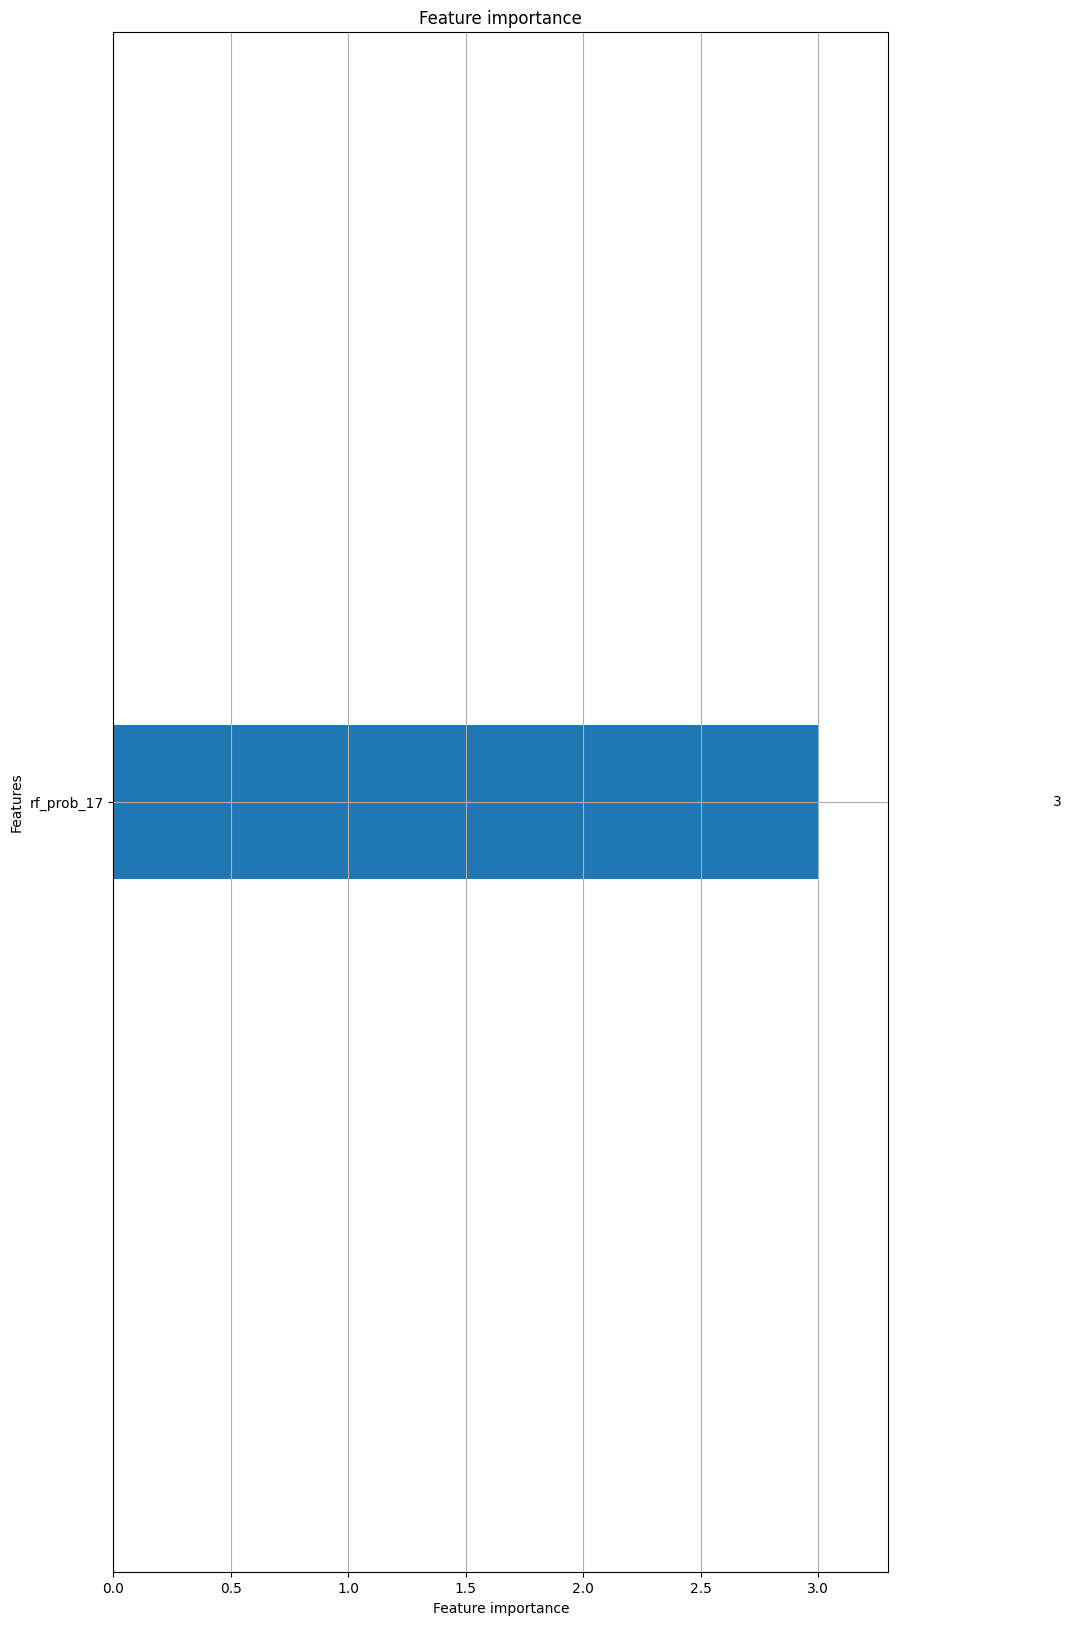

In [ ]:
lgb.plot_importance(model, figsize=(10, 20))
plt.show()


Y si queremos tener las variables más importantes en forma de *Dataframe*:

In [ ]:
importances = model.feature_importance()
feature_names = X_train.columns.tolist()
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
importance_df = importance_df.sort_values('importance', ascending=False)
importance_df[importance_df['importance'] > 0]


,feature,importance
154,rf_prob_17,3


Para guardar el modelo para poder utilizarlo más adelante, no es necesario guardarlo como *pickle*, la librería nos permite guardarlo en formato texto

In [ ]:
model.save_model(modelos_path + 'lgb_muy_ampliada_abril.txt')

Y recuperar el mismo desde ese formato

In [ ]:
model = lgb.Booster(model_file=modelos_path + 'lgb_muy_ampliada_abril.txt')

Ahora vamos a entrenar en **Abril  marzo** y predecir en  **Junio**

> Añadir blockquote



# Entrenar en Abril

In [ ]:
train_data = lgb.Dataset(X_train,
                          label=y_train_binaria2,
                          weight=w_train)

model = lgb.train(params,
                  train_data,
                  num_boost_round=best_iter)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


## Predecir en junio

In [ ]:
y_pred=model.predict(X_test)

## Enviar a Kaggle



In [ ]:
# Cargo el kaggle.json para poder conectarme
import os
import shutil

# Mueve kaggle.json al directorio correcto
os.makedirs('/root/.kaggle', exist_ok=True)
kaggle_json_path="/content/drive/MyDrive/Data Science y similares/Maestría Data Mining Exactas"
shutil.copy(f'{kaggle_json_path}/kaggle.json', '/root/.kaggle/kaggle.json')
os.chmod('/root/.kaggle/kaggle.json', 600)



In [ ]:
  # En y_pred está la predicción hecha sobre junio
  # En X_test los datos de junio sobre los que se hizo la predicción

  # Obtengo el orden de prioridad para el envío
idx_deseables=np.argsort(y_pred)[::-1]



  # ------------------------------------------------------------------
for envios in np.linspace(min_envios, max_envios, cant_envios, dtype=int):
    print (f"Enviando: {envios}")
    # Notar que idx_deseables tiene índices de y_pred (de 0 al máximo de línes de y_pred)

    # los primeros envíos irán con predicción 1 y el resto 0
    # idx_deseables contiene los índices de y_pred (no los originales!!) cuyas predicciones tienen los mejores valores, en orden desdendente
    # guardo en elegidos los índices de los datos correspondientes a los primeros :envios en idx
    elegidos=X_test.index[idx_deseables[:envios]]

    # Creo clientes_kaggle sólo con el número de cliente de  X_test
    clientes_kaggle=X_test.loc[:, ['numero_de_cliente']].copy()
    clientes_kaggle['Predicted']=0    #default
    clientes_kaggle.loc[elegidos, 'Predicted'] = 1   # marco los "enviados"

  if clientes_kaggle.shape != ( 115810, 2):
       raise ValueError(f"El DataFrame 'clientes_enviados' no tiene la forma esperada. Forma actual: {clientes_kaggle.shape}")
   else:
       print("La forma de 'clientes_enviados' es correcta.")

    # elijo el nombre para el archivo enviar, para llevar control
    # un mensaje para registrar
    # y me grabo el archivo que mando para tener control local
    version=31
    # Voy a mandar con un mensaje que incluya los parámetros usados y la cantidad de envíos
    mensaje=f"lgbm muy aumentada semilla {semilla} {params} entrenado abril-marzo pred junio envios {envios}"
    # Me gusta guardar los envíos que hago
    archivo=f"k601_{str(version).zfill(3)}-{envios}.csv"
    path_archivo=dataset_path+archivo
    clientes_kaggle.to_csv(path_archivo, index=False)

    # Envío a la competencia
    competencia="dm-ey-f-2024-segunda"
    !kaggle competitions submit -c {competencia} -f '{path_archivo}' -m '{mensaje}'




Enviando: 8500
100% 60.3k/60.3k [00:00<00:00, 95.0kB/s]
Successfully submitted to DMEyF 2024 Segunda

In [ ]:
params_str = str(params)

# Eliminar llaves {}, apóstrofes ' y dos puntos :
params_str = params_str.replace('{', '').replace('}', '').replace("'", '').replace(':', '').replace(",",'')
params_str

'objective binary boosting_type gbdt first_metric_only True boost_from_average True feature_pre_filter False max_bin 31 num_leaves 64 learning_rate 0.2552443617349033 min_data_in_leaf 1115 feature_fraction 0.941815705991754 bagging_fraction 0.33981784232945744 min_gain_to_split 0.998175967829833 seed 23 verbose 0'

In [ ]:
clientes_kaggle

,numero_de_cliente,Predicted
0,596043405,1
1,324054194,1
2,1200152394,1
3,1302835593,1
4,858495587,1
...,...,...
10188,838737895,1
10189,510087052,1
10193,848154891,1
10194,271864454,1
